In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers


train_dir = "/content/drive/MyDrive/Covid19-dataset/train"
test_dir = "/content/drive/MyDrive/Covid19-dataset/test"


classes = ["Covid", "Viral Pneumonia"]

train_counts = {cls: 0 for cls in classes}
test_counts = {cls: 0 for cls in classes}

for cls in classes:
    class_dir = os.path.join(train_dir, cls)
    train_counts[cls] = len(os.listdir(class_dir))

for cls in classes:
    class_dir = os.path.join(test_dir, cls)
    test_counts[cls] = len(os.listdir(class_dir))

for cls in classes:
    print(f"Training images in '{cls}': {train_counts[cls]}")
    print(f"Testing images in '{cls}': {test_counts[cls]}")


Training images in 'Covid': 111
Testing images in 'Covid': 26
Training images in 'Viral Pneumonia': 70
Testing images in 'Viral Pneumonia': 20


In [ ]:
# Image dimensions
image_width = 224
image_height = 224
batch_size = 32

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Only normalization for test data

# Create data generators for training and testing
train_data_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_data_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Check the class indices
class_indices = train_data_generator.class_indices
print("Class Indices:", class_indices)


Found 181 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Class Indices: {'Covid': 0, 'Viral Pneumonia': 1}


In [ ]:
# Define the model
model = keras.Sequential([
    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the feature maps for the fully connected layers
    layers.Flatten(),

    # Fully Connected Layer 1
    layers.Dense(128, activation='relu'),

    # Output Layer with 2 units (binary classification)
    layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 26, 26, 128)      

In [ ]:
# Define the number of training and testing steps per epoch
train_steps_per_epoch = len(train_data_generator)
test_steps_per_epoch = len(test_data_generator)

# Fit the model
history = model.fit(
    train_data_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=test_data_generator,
    validation_steps=test_steps_per_epoch
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/10
6/6 [==============================] - 39s 7s/step - loss: 0.6833 - accuracy: 0.6077 - val_loss: 0.4729 - val_accuracy: 0.9783
Epoch 2/10
6/6 [==============================] - 29s 5s/step - loss: 0.5014 - accuracy: 0.7956 - val_loss: 0.1670 - val_accuracy: 0.9783
Epoch 3/10
6/6 [==============================] - 35s 6s/step - loss: 0.3594 - accuracy: 0.8122 - val_loss: 0.3361 - val_accuracy: 0.9130
Epoch 4/10
6/6 [==============================] - 27s 4s/step - loss: 0.2620 - accuracy: 0.9227 - val_loss: 0.2512 - val_accuracy: 0.9130
Epoch 5/10
6/6 [==============================] - 29s 4s/step - loss: 0.2558 - accuracy: 0.9116 - val_loss: 0.2121 - val_accuracy: 0.9130
Epoch 6/10
6/6 [==============================] - 28s 4s/step - loss: 0.2306 - accuracy: 0.9116 - val_loss: 0.2413 - val_accuracy: 0.9348
Epoch 7/10
6/6 [==============================] - 28s 4s/step - loss: 0.1955 - accuracy: 0.9337 - val_loss: 0.2065 - val_accuracy: 0.9348
Epoch 8/10
6/6 [==================

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Load and preprocess new images (adjust as needed)
new_image_paths = ["/content/drive/MyDrive/Covid19-dataset/test/Covid/0100.jpeg","/content/drive/MyDrive/Covid19-dataset/test/Viral Pneumonia/0101.jpeg"]
new_images = []

for image_path in new_image_paths:
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(image_width, image_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize pixel values
    new_images.append(img)

new_images = np.vstack(new_images)

# Predict class probabilities for new images
predictions = model.predict(new_images)
# Define true labels for the new images (0 for 'Covid' and 1 for 'Viral Pneumonia')
true_labels = [0, 1]

# Evaluate class-specific metrics
accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))
precision = precision_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
recall = recall_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
f1 = f1_score(true_labels, np.argmax(predictions, axis=1), average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


1/1 [==============================] - 0s 76ms/step
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [ ]:
from sklearn.metrics import classification_report
# Generate classification report

y_pred_classes = np.argmax(predictions, axis=1)
class_names = ['Abnormal','Normal']  # Replace with your class names
report = classification_report(true_labels, y_pred_classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    Abnormal       1.00      1.00      1.00         1
      Normal       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



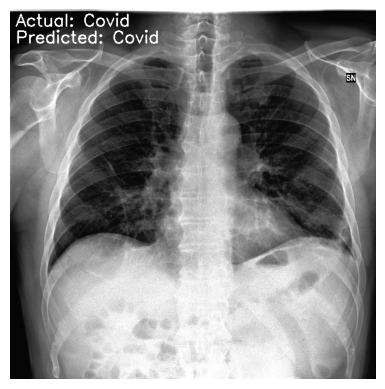

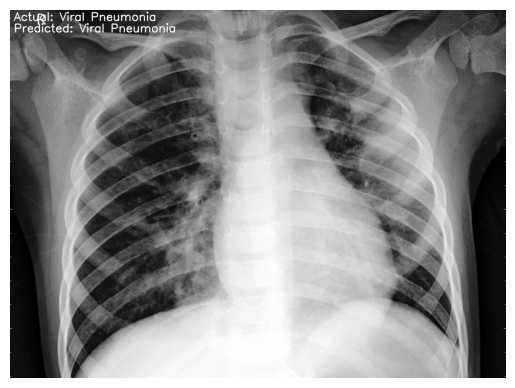

In [ ]:
import cv2
import seaborn as sns

# Overlay actual and predicted labels on the new images and display them
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (255, 255, 255)
thickness = 2

for i, image_path in enumerate(new_image_paths):
    img = cv2.imread(image_path)
    actual_label = "Actual: Covid" if true_labels[i] == 0 else "Actual: Viral Pneumonia"
    predicted_label = "Predicted: Covid" if np.argmax(predictions[i]) == 0 else "Predicted: Viral Pneumonia"

    cv2.putText(img, actual_label, (10, 30), font, font_scale, font_color, thickness)
    cv2.putText(img, predicted_label, (10, 60), font, font_scale, font_color, thickness)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


Confusion Matrix:
[[1 0]
 [0 1]]


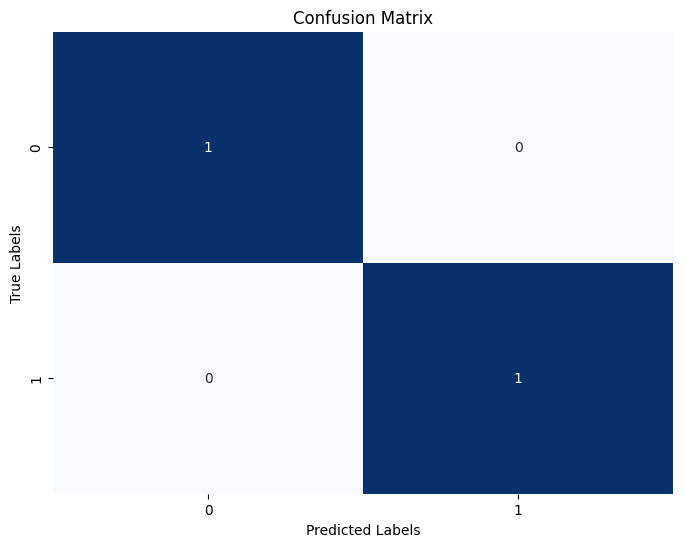

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, np.argmax(predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


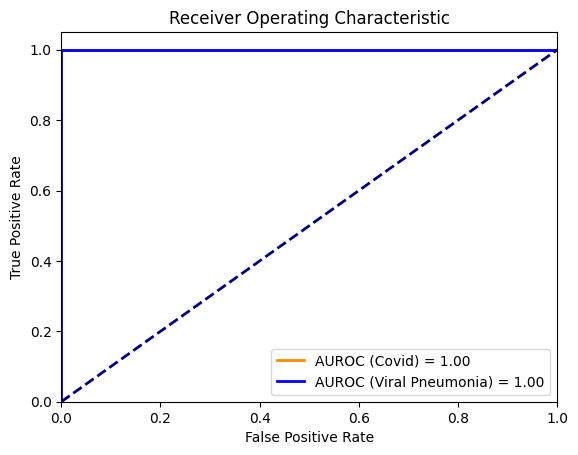

In [ ]:
# Calculate and plot the ROC curve for each class
fpr, tpr, thresholds = roc_curve(true_labels, predictions[:, 0], pos_label=0)  # 'Abnormal'
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUROC (Covid) = {roc_auc:.2f}')

fpr, tpr, thresholds = roc_curve(true_labels, predictions[:, 1], pos_label=1)  # 'Normal'
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC (Viral Pneumonia) = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

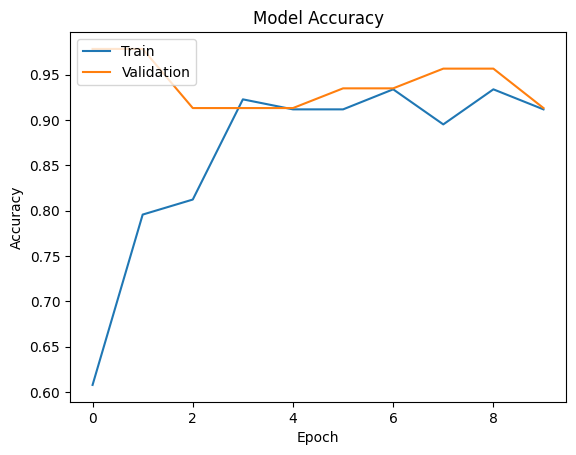

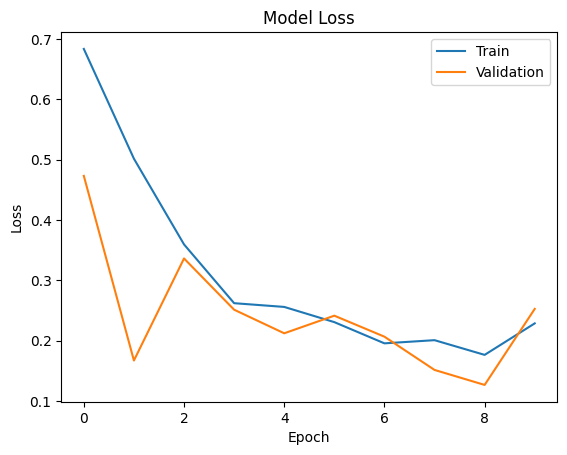

In [ ]:

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

